In [1]:
import xarray
import spires
import numpy as np
import matplotlib.pyplot as plt

In [2]:
interpolator = spires.LutInterpolator(lut_file='../tests/data/lut_sentinel2b_b2to12_3um_dust.mat')
bands = interpolator.bands
solar_angles = interpolator.solar_angles
dust_concentrations = interpolator.dust_concentrations
grain_sizes = interpolator.grain_sizes
reflectances = interpolator.reflectances

In [3]:
r = xarray.load_dataset('../tests/data/sentinel_r.nc')
r0 = xarray.load_dataset('../tests/data/sentinel_r0.nc')
x0 = np.array([0.5, 0.05, 10, 250])

In [17]:
ds = xarray.Dataset()
ds['r'] = r['reflectance']
ds['r0'] = r0['reflectance']
ds['solar_z'] = r['sun_zenith_grid']
ds

<xarray.Dataset> Size: 144MB
Dimensions:  (band: 9, time: 2, x: 1347, y: 921)
Coordinates:
  * band     (band) <U3 108B 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B11' 'B12' 'B8'
  * time     (time) datetime64[ns] 16B 2024-02-25T18:43:39.024000 2024-03-01T...
  * x        (x) float64 11kB 3.146e+05 3.146e+05 ... 3.28e+05 3.28e+05
  * y        (y) float64 7kB 4.171e+06 4.171e+06 ... 4.162e+06 4.162e+06
Data variables:
    r        (time, band, y, x) float32 89MB 0.5558 0.2196 ... 0.8392 0.8392
    r0       (band, y, x) float32 45MB 0.0496 0.0238 0.0296 ... 0.128 0.2752
    solar_z  (time, x, y) float32 10MB 50.02 50.02 50.02 ... 48.0 48.0 48.0

# Take a single day

In [38]:
date = '2024-02-25'
ts = ds.sel(time=date).squeeze().drop_vars('time')

# Using the Core function (i.e. an with output argument)
the function is abstracted in `spires.invert_array2d()`

In [41]:
spectra_targets = ts['r'].transpose('y', 'x', 'band')
spectra_backgrounds = ts['r0'].transpose('y', 'x', 'band')
obs_solar_angles = ts['solar_z'].transpose('y', 'x')
spectrum_shade = np.zeros_like(spectra_targets[0,0,:])
spectra_targets.shape
results = np.empty((spectra_targets.y.size, spectra_targets.x.size, 4), dtype=np.double)

In [42]:
%%time
spires.core.invert_array2d(spectra_backgrounds=spectra_backgrounds, 
                           spectra_targets=spectra_targets, 
                           spectrum_shade=spectrum_shade, 
                           obs_solar_angles=obs_solar_angles, 
                           bands=bands, solar_angles=solar_angles, dust_concentrations=dust_concentrations, grain_sizes=grain_sizes, lut=reflectances, 
                           results=results, 
                           max_eval=100, 
                           x0=x0, 
                           algorithm=2)

CPU times: user 50 s, sys: 100 ms, total: 50.1 s
Wall time: 50.2 s


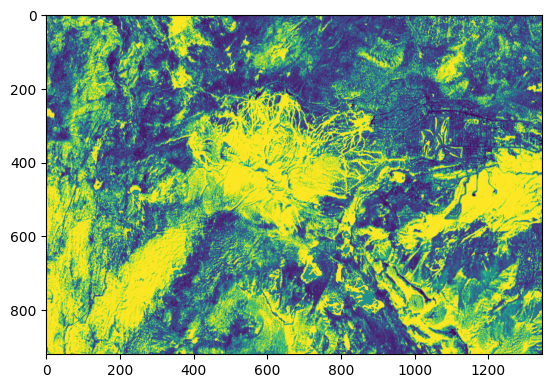

In [43]:
plt.imshow(results[:,:, 0])

# High level functions

In [36]:
%%time
results = spires.speedy_invert_array1d(spectra_targets=spectra_targets.stack(location=('y', 'x')).transpose('location', 'band'),
                                       spectra_backgrounds=spectra_backgrounds.stack(location=('y', 'x')).transpose('location', 'band'),
                                       obs_solar_angles=obs_solar_angles.stack(location=('y', 'x')),
                                       interpolator=interpolator)

CPU times: user 50.5 s, sys: 160 ms, total: 50.6 s
Wall time: 50.6 s


In [32]:
spectra_targets = ts['r']
spectra_backgrounds = ts['r0']
obs_solar_angles = ts['solar_z']
x0 = np.array([0.5, 0.05, 10, 250])

# Attempting to parallelize with dask
This won't work since `speedy_invert_array2d` expects an xarray

In [33]:
def invert_xarray(spectra_targets, spectra_backgrounds, obs_solar_angles, bands, solar_angles, dust, grain, reflectances):       
    spectra_targets = spectra_targets.squeeze()
    obs_solar_angles = obs_solar_angles.squeeze()
    results = spires.speedy_invert_array2d(spectra_targets=spectra_targets, 
                                           spectra_backgrounds=spectra_backgrounds, 
                                           obs_solar_angles=obs_solar_angles,                                            
                                           bands=bands,
                                           solar_angles=solar_angles,
                                           dust_concentrations=dust,
                                           grain_sizes=grain,
                                           reflectances=reflectances,                                                                                      
                                           max_eval=100,
                                           x0=x0, 
                                           algorithm=2)
    results = np.expand_dims(results, axis=0)
    return results

In [34]:
results = xarray.apply_ufunc(invert_xarray,
                             spectra_targets,
                             spectra_backgrounds,  
                             obs_solar_angles,
                             interpolator.bands,
                             interpolator.solar_angles,
                             interpolator.dust_concentrations,
                             interpolator.grain_sizes,       
                             interpolator.reflectances,                   
                             dask='parallelized',
                             input_core_dims=[['band'], ['band'], [], ['bands'], ['sz'], ['dust'], ['grain'], ['bands', 'sz', 'dust', 'grain']],
                             output_core_dims=[['property']],
                             dask_gufunc_kwargs={'allow_rechunk': False, 'output_sizes': {'property': 4}},
                             output_dtypes=[float],
                             vectorize=False)

TypeError: 'str' object cannot be interpreted as an integer

In [35]:
results = results.to_dataset(dim='property').rename({0: 'fsca', 1: 'fshade', 2: 'dust', 3: 'grain'})
results

NameError: name 'results' is not defined

### 